# Download and store images

Create dataset by assembling and resizing images

## Config

In [69]:
import pandas as pd
import numpy as np
from simple_image_download import simple_image_download as simp
import shutil
from glob import glob
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from typing import Tuple, Dict
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import gbif_dl
import sqlalchemy as sqa

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.propagate = False

In [6]:
# Google image download parameters
n_positive_examples = 2500
n_negative_examples = 2500

positive_terms = ["poison ivy plant"]

default_download_path = Path("simple_images")
store_path = Path("../datasets/pipeline_v1/downloaded_images")
metadata_loc = Path("../datasets/pipeline_v1/downloaded_images/image_metadata.csv")

similar_plants = [
    "Box elder",
    "Virgin's bower",
    "Virginia creeper",
    "Western poison oak",
    "Poison sumac",
    "Kudzu",
    "Blackberries",
    "Strawberries",
    "Fragrant sumac",
    "Hoptree",
] # Source: "https://en.wikipedia.org/wiki/Toxicodendron_radicans"
negative_terms = [f"{plant} plant" for plant in similar_plants]

# Plantnet parameters
PLANTNET_KEY = "7a3679ef-5582-4aaa-81f0-8c2545cafc81"
plantnet_dl_target_path = Path("../datasets/pipeline_v1/plantnet_raw")
n_plantnet_examples = 2000


# ImageNet parameters
imagenet_download_path = Path("../datasets/pipeline_v1/imagenet_mini_raw/val")
imagenet_term_dict_path = Path("../datasets/pipeline_v1/imagenet_mini_raw/words.txt")

# Database parameters
db_container = "metadata_db"
db_user = "pguser"
db_password = "pgpassword"
db_port = 5432
db_database = "metadata"
db_prefix = "postgresql"
metadata_tbl = "base_images"

In [7]:
def resize_by_min_dim(size: Tuple[int, int], min_dim:int =100) -> Tuple[int, int]:
    """
    Resize an image to keep the same proportions and make the smaller
    of the two dimensions equal to min_dim
    size = (width, height) in pixels
    returns (new_width, new_height)
    """
    width, height = size
    if (width <= min_dim) or (height <= min_dim):  # No need to resize images which are already small enough
        return size
    new_height = new_width = None
    if width > height:
        new_height = min_dim
        new_width = int((width/height) * new_height)
    else:
        new_width = min_dim
        new_height = int((height/width) * new_width)
    return (new_width, new_height)
    

def download_images(search_term: str, count: int = 5):
    """
    Downloads images based on search terms to simple_images folder
    """
    # Clear download space so we only keep downloaded images
    src_folder = Path("simple_images")  # default property of simple_image_download package
    if src_folder.exists():
        shutil.rmtree(str(src_folder))
    downloader = simp.simple_image_download()
    logging.info(f"Starting download for: {search_term} x {count}")
    downloader.download(search_term, count)
    logging.info(f"Downloaded images for: {search_term} x {count}")
        
    
    

In [8]:
def gather_and_store_image_script(search_term_counts: Dict[str, int],
                                  dest_dir: str,
                                  img_min_dimen: int = 500,
                                  clean_dest_dir: bool = False) -> pd.DataFrame:
    """
    Downloads google image based on a dict of search terms: count of images to download
    Downsizes image if they are too large by putting smaller dimension to min_dimen and keeping aspect ratio
    If clean_dest_dir, remove all data from destination first
    Returns a dataframe of the results
    """
    dest_path = Path(dest_dir)
    if dest_path.exists() and (clean_dest_dir == True):
      shutil.rmtree(dest_path)
      dest_path.mkdir(parents=True, exist_ok=True)
    if not dest_path.exists():
      dest_path.mkdir(parents=True, exist_ok=True)
    
    download_dir = Path("simple_images")
    image_metadata = []
    img_data = {}
    
    
    for search_term, count in search_term_counts.items():
      download_images(search_term, count)
      for img_loc in glob(str(Path(download_dir, search_term, '*'))):
        img_path = Path(img_loc)
        file_name = img_path.name.replace(" ", "_")
        dest_loc = Path(dest_path, file_name)
        
        img_data = {
          "download_loc": str(img_path),
          "final_loc": str(dest_loc),
          "full_path": str(dest_loc.absolute().resolve()),
          "search_term": search_term,
          "source": "Google Images",
          "file_name": file_name,
          "download_name": img_path.name
        }
        
        try:
          img = Image.open(img_path).convert('RGB')
          img_data['read'] = True
        except UnidentifiedImageError:
          img_data['read'] = False
        
        if img_data['read']:
          img_data['orig_width'], img_data['orig_height'] = img.size
          img_data['width'], img_data['height'] = resize_by_min_dim((img_data['orig_width'],
                                                                     img_data['orig_height']), min_dim=500)
          resized_img = img.resize((img_data['width'], img_data['height']), Image.ANTIALIAS)
          resized_img.save(img_data['final_loc'], 'JPEG', quality=90)
        
        image_metadata.append(img_data)
    if download_dir.exists():
      shutil.rmtree(str(download_dir))

    return(pd.DataFrame(image_metadata).set_index("file_name"))
    

In [9]:
%%time
# Positive images
n_positive_each = int(n_positive_examples / len(positive_terms))
df_pos = gather_and_store_image_script({pos_term: n_positive_each
                                        for pos_term in positive_terms},
                                       str(Path(store_path, 'positive')))
df_pos['label'] = 1
df_pos['label_str'] = 'positive'

INFO:Starting download for: poison ivy plant x 2500


('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end close

INFO:Downloaded images for: poison ivy plant x 2500
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


CPU times: user 3min 54s, sys: 16.3 s, total: 4min 10s
Wall time: 20min 33s


In [11]:
%%time
# Negative images
n_negative_each = int(n_negative_examples / len(negative_terms))
df_neg = gather_and_store_image_script({neg_term: n_negative_each
                                        for neg_term in negative_terms},
                                       str(Path(store_path, 'negative')),
                                       clean_dest_dir=False)
df_neg['label'] = 0
df_neg['label_str'] = 'negative'

INFO:Starting download for: Box elder plant x 250
INFO:Downloaded images for: Box elder plant x 250
INFO:Starting download for: Virgin's bower plant x 250
INFO:Downloaded images for: Virgin's bower plant x 250
INFO:Starting download for: Virginia creeper plant x 250


('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))


INFO:Downloaded images for: Virginia creeper plant x 250
INFO:Starting download for: Western poison oak plant x 250


HTTPSConnectionPool(host='cleverhomestead.com', port=443): Max retries exceeded with url: /wp-content/uploads/2013/12/poison-ivy-eastern-western-toxicodendron-radicans-rydbergii-featured-1280x640.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6d8d04db00>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='cleverhomestead.com', port=443): Max retries exceeded with url: /wp-content/uploads/2013/12/poison-ivy-eastern-western-toxicodendron-radicans-rydbergii-featured-1280x640.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6d8d04efd0>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='cleverhomestead.com', port=443): Max retries exceeded with url: /wp-content/uploads/2013/12/poison-ivy-eastern-western-toxicodendron-radicans-rydbergii-featured-1280x640.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection

INFO:Downloaded images for: Western poison oak plant x 250
INFO:Starting download for: Poison sumac plant x 250


HTTPSConnectionPool(host='cleverhomestead.com', port=443): Max retries exceeded with url: /wp-content/uploads/2013/02/poison-sumac-toxicodendron-vernix-featured-1280x640.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6d8d049da0>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='cleverhomestead.com', port=443): Max retries exceeded with url: /wp-content/uploads/2013/02/poison-sumac-toxicodendron-vernix-featured-1280x640.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6d8d0066d8>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='cleverhomestead.com', port=443): Max retries exceeded with url: /wp-content/uploads/2013/02/poison-sumac-toxicodendron-vernix-featured-1280x640.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6d8d006470>: Failed to establish a new connection: [Errno 111] 

INFO:Downloaded images for: Poison sumac plant x 250
INFO:Starting download for: Kudzu plant x 250


('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', OSError(0, 'Error'))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', OSError(0, 'Error'))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))
('Connection aborted.', OSError(0, 'Error'))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))


INFO:Downloaded images for: Kudzu plant x 250
INFO:Starting download for: Blackberries plant x 250


HTTPSConnectionPool(host='www.willisorchards.com', port=443): Max retries exceeded with url: //system/products/images/858/original/natchez_thornless_blackberry_plant-image2.jpg?1370582558 (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))
HTTPSConnectionPool(host='www.willisorchards.com', port=443): Max retries exceeded with url: //system/products/images/858/original/natchez_thornless_blackberry_plant-image2.jpg?1370582558 (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))
HTTPSConnectionPool(host='www.willisorchards.com', port=443): Max retries exceeded with url: //system/products/images/858/original/natchez_thornless_blackberry_plant-image2.jpg?1370582558 (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))


INFO:Downloaded images for: Blackberries plant x 250
INFO:Starting download for: Strawberries plant x 250


HTTPSConnectionPool(host='wiki.nurserylive.com', port=443): Max retries exceeded with url: /uploads/default/original/1X/5d4fca7fec9be8618e016588350d62ad547a1691.png (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))
HTTPSConnectionPool(host='wiki.nurserylive.com', port=443): Max retries exceeded with url: /uploads/default/original/1X/5d4fca7fec9be8618e016588350d62ad547a1691.png (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))
HTTPSConnectionPool(host='wiki.nurserylive.com', port=443): Max retries exceeded with url: /uploads/default/original/1X/5d4fca7fec9be8618e016588350d62ad547a1691.png (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))


INFO:Downloaded images for: Strawberries plant x 250
INFO:Starting download for: Fragrant sumac plant x 250


HTTPSConnectionPool(host='64.209.142.95', port=443): Max retries exceeded with url: /images/products/rhus_lacette.jpg (Caused by SSLError(CertificateError("hostname '64.209.142.95' doesn't match either of 'www.estabrooksonline.com', 'estabrooksonline.com'",),))


HTTPSConnectionPool(host='64.209.142.95', port=443): Max retries exceeded with url: /images/products/rhus_lacette.jpg (Caused by SSLError(CertificateError("hostname '64.209.142.95' doesn't match either of 'www.estabrooksonline.com', 'estabrooksonline.com'",),))


HTTPSConnectionPool(host='64.209.142.95', port=443): Max retries exceeded with url: /images/products/rhus_lacette.jpg (Caused by SSLError(CertificateError("hostname '64.209.142.95' doesn't match either of 'www.estabrooksonline.com', 'estabrooksonline.com'",),))


INFO:Downloaded images for: Fragrant sumac plant x 250
INFO:Starting download for: Hoptree plant x 250


HTTPSConnectionPool(host='centraldata.gardenconnect.com', port=443): Max retries exceeded with url: /files/images/plantguide/plant_3011dda0aa_n.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6d8cf27eb8>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='centraldata.gardenconnect.com', port=443): Max retries exceeded with url: /files/images/plantguide/plant_b984a5c4de_n.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6d8cf27278>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='centraldata.gardenconnect.com', port=443): Max retries exceeded with url: /files/images/plantguide/plant_3011dda0aa_n.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f6d8cfd22e8>: Failed to establish a new connection: [Errno 111] Connection refused',))
HTTPSConnectionPool(host='centraldata.gardenconnect.com

INFO:Downloaded images for: Hoptree plant x 250


CPU times: user 2min 47s, sys: 9.05 s, total: 2min 56s
Wall time: 19min 43s


## Supplement with ImageNet and PlantNet data 

### Plantnet Data

In [12]:

def gather_and_store_plantnet_images(dest_dir: str, download_dir: str,
                                     nb_samples: int =5, min_dim: int = 5) -> pd.DataFrame:
    """
    Downloads images via gbif_dl from Plantnet database
    Resizes and moves to dest_dir for final storage
    """
    # Download images based on query
    query = {
        "datasetKey": [
            PLANTNET_KEY,
        ]
    }
    data_generator = gbif_dl.api.generate_urls(
        queries=query,
        label="speciesKey",
        nb_samples=nb_samples)
    gbif_dl.io.download(data_generator, root=download_dir)
    logging.info("Downloaded images")

    # Move + resize images, store metadata    
    image_metadata = []
    dest_path = Path(dest_dir)
    for n_iter, img_loc in enumerate(glob(str(Path(plantnet_dl_target_path, '**', '*')))):
        img_path = Path(img_loc)
        species_code = img_path.parents[0].name
        file_name = f"Plantnet_image-{n_iter+1}_species-{species_code}.jpg"
        download_name = img_path.name
        dest_loc = Path(dest_path, file_name)
            
        img_data = {
            "download_loc": str(img_path),
            "final_loc": str(dest_loc),
            "full_path": str(dest_loc.absolute().resolve()),
            "search_term": species_code,
            "source": "Plantnet",
            "file_name": file_name,
            "download_name": download_name
        }
            
        try:
            img = Image.open(img_path).convert('RGB')
            img_data['read'] = True
        except UnidentifiedImageError:
            img_data['read'] = False
        
        if img_data['read']:
            img_data['orig_width'], img_data['orig_height'] = img.size
            img_data['width'], img_data['height'] = resize_by_min_dim((img_data['orig_width'],
                                                                        img_data['orig_height']), min_dim=min_dim)
            resized_img = img.resize((img_data['width'], img_data['height']), Image.ANTIALIAS)
            resized_img.save(img_data['final_loc'], 'JPEG', quality=90)
        
        image_metadata.append(img_data)
    return(pd.DataFrame(image_metadata).set_index("file_name"))


In [13]:
%%time
df_PN = gather_and_store_plantnet_images(dest_dir=str(Path(store_path, 'negative')),
                                         download_dir=str(plantnet_dl_target_path),
                                         nb_samples=n_plantnet_examples)
df_PN['label'] = 0
df_PN['label_str'] = 'negative'

2000


2000 Files [00:12, 153.91 Files/s]
INFO:Downloaded images


CPU times: user 32 s, sys: 472 ms, total: 32.4 s
Wall time: 45.9 s


### Imagenet

Imagenet images were downloaded directly from: https://www.kaggle.com/ifigotin/imagenetmini-1000

In [14]:
imagenet_term_dict = {}
with open(imagenet_term_dict_path, 'r') as f:
    for i, line in enumerate(f.readlines()):
        term_id, terms = line.split(None, maxsplit=1)
        imagenet_term_dict[term_id] = terms.replace('\n', '')

In [15]:
[*imagenet_term_dict.values()][-20:]

['shiva, shivah, shibah',
 'epoch, date of reference',
 'clotting time',
 'rotational latency, latency',
 'probation',
 'probation',
 'processing time',
 'air alert',
 'command processing overhead time, command processing overhead, command overhead, overhead',
 'Great Schism',
 'question time',
 'real time',
 'real time',
 'regency',
 'snap',
 'study hall',
 'Transfiguration, Transfiguration Day, August 6',
 'usance',
 'window',
 '9/11, 9-11, September 11, Sept. 11, Sep 11']

In [16]:

def gather_and_store_local_downloaded_images(dest_dir: str, local_download_dir: str,
                                             term_dict: Dict[str, str],
                                             min_dim: int = 500,
                                             source_name: str = "Imagenet") -> pd.DataFrame:
    """
    Gathers pre-downloaded images stored in a local directory
    Moves destination directory
    Resizes images down to have a smaller dimension of "min_dim" and stores as jpg
    Uses nid_dict to assign search terms from subfolder names
    Stores metadata in dataframe and returns dataframe
    """

    # Move + resize images, store metadata    
    image_metadata = []
    dest_path = Path(dest_dir)
    for n_iter, img_loc in enumerate(glob(str(Path(local_download_dir, '**', '*')))):
        img_path = Path(img_loc)
        image_key = img_path.parents[0].name
        image_term = term_dict[image_key]
        file_name = f"{source_name}_image-{n_iter+1}_term_{image_key}.jpg"
        download_name = img_path.name
        dest_loc = Path(dest_path, file_name)
            
        img_data = {
            "download_loc": str(img_path),
            "final_loc": str(dest_loc),
            "full_path": str(dest_loc.absolute().resolve()),
            "search_term": f"{image_key}: {image_term}",
            "source": source_name,
            "file_name": file_name,
            "download_name": download_name
        }
            
        try:
            img = Image.open(img_path).convert('RGB')
            img_data['read'] = True
        except UnidentifiedImageError:
            img_data['read'] = False
        
        if img_data['read']:
            img_data['orig_width'], img_data['orig_height'] = img.size
            img_data['width'], img_data['height'] = resize_by_min_dim((img_data['orig_width'],
                                                                        img_data['orig_height']), min_dim=min_dim)
            resized_img = img.resize((img_data['width'], img_data['height']), Image.ANTIALIAS)
            resized_img.save(img_data['final_loc'], 'JPEG', quality=90)
        
        image_metadata.append(img_data)
    return(pd.DataFrame(image_metadata).set_index("file_name"))


In [50]:
%%time
df_IN = gather_and_store_local_downloaded_images(dest_dir=str(Path(store_path, 'negative')),
                                                 local_download_dir=str(imagenet_download_path),
                                                 term_dict=imagenet_term_dict,
                                                 source_name="Imagenet")

df_IN['label'] = 0
df_IN['label_str'] = 'negative'

CPU times: user 50.2 s, sys: 5.5 s, total: 55.7 s
Wall time: 55.7 s


In [51]:
df_IN.head()

,download_loc,final_loc,full_path,search_term,source,download_name,read,orig_width,orig_height,width,height,label,label_str
file_name,,,,,,,,,,,,,
Imagenet_image-1_term_n01689811.jpg,../datasets/pipeline_v1/imagenet_mini_raw/val/...,../datasets/pipeline_v1/downloaded_images/nega...,/home/code/datasets/pipeline_v1/downloaded_ima...,n01689811: alligator lizard,Imagenet,ILSVRC2012_val_00016357.JPEG,True,500,375,500,375,0,negative
Imagenet_image-2_term_n01689811.jpg,../datasets/pipeline_v1/imagenet_mini_raw/val/...,../datasets/pipeline_v1/downloaded_images/nega...,/home/code/datasets/pipeline_v1/downloaded_ima...,n01689811: alligator lizard,Imagenet,ILSVRC2012_val_00038667.JPEG,True,500,387,500,387,0,negative
Imagenet_image-3_term_n01689811.jpg,../datasets/pipeline_v1/imagenet_mini_raw/val/...,../datasets/pipeline_v1/downloaded_images/nega...,/home/code/datasets/pipeline_v1/downloaded_ima...,n01689811: alligator lizard,Imagenet,ILSVRC2012_val_00043624.JPEG,True,500,375,500,375,0,negative
Imagenet_image-4_term_n04591713.jpg,../datasets/pipeline_v1/imagenet_mini_raw/val/...,../datasets/pipeline_v1/downloaded_images/nega...,/home/code/datasets/pipeline_v1/downloaded_ima...,n04591713: wine bottle,Imagenet,ILSVRC2012_val_00028267.JPEG,True,375,500,375,500,0,negative
Imagenet_image-5_term_n04591713.jpg,../datasets/pipeline_v1/imagenet_mini_raw/val/...,../datasets/pipeline_v1/downloaded_images/nega...,/home/code/datasets/pipeline_v1/downloaded_ima...,n04591713: wine bottle,Imagenet,ILSVRC2012_val_00021988.JPEG,True,463,500,463,500,0,negative


## Analyze and store metadata

In [52]:
df_ims = pd.concat([df_pos, df_neg, df_PN, df_IN])
df_ims.head()

,download_loc,final_loc,full_path,search_term,source,read,orig_width,orig_height,width,height,label,label_str,download_name
file_name,,,,,,,,,,,,,
poison_ivy_plant_1095.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,1024.0,575.0,890.0,500.0,1,positive,NaN
poison_ivy_plant_1556.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,750.0,500.0,750.0,500.0,1,positive,NaN
poison_ivy_plant_1294.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,1800.0,1013.0,888.0,500.0,1,positive,NaN
poison_ivy_plant_964.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,480.0,310.0,480.0,310.0,1,positive,NaN
poison_ivy_plant_1526.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,1600.0,1031.0,775.0,500.0,1,positive,NaN


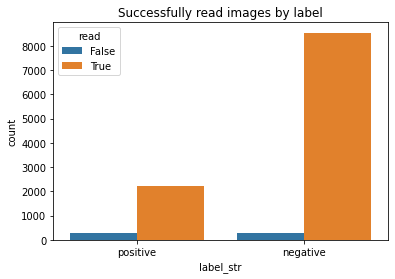

In [53]:
sns.countplot(data=df_ims, x='label_str', hue='read')
plt.title("Successfully read images by label")
plt.show()

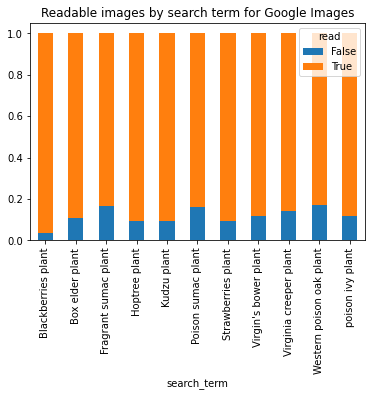

In [54]:
df_plot = df_ims[df_ims['source'] == 'Google Images']
term_counts = df_plot['search_term'].value_counts()

df_plot = df_plot.groupby(['search_term', 'read'])[['label_str']] \
    .count() \
    .rename({'label_str': 'count'}, axis=1) \
    .reset_index()
    
df_plot['frac'] = df_plot.apply(lambda row: row['count'] / term_counts[row['search_term']], axis=1)
# df_plot.set_index('read').unstack()
df_plot = df_plot.set_index(['search_term', 'read']).unstack()
df_plot.plot.bar(y='frac', stacked=True, title='Readable images by search term for Google Images')
plt.show()
# sns.barplot(data=df_plot, x='search_term', y='frac', hue='read', dodge=False, s)

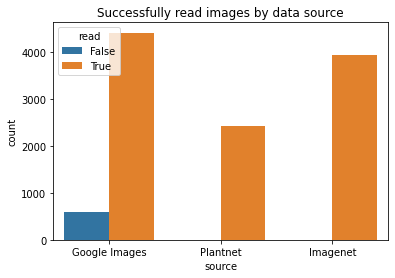

In [55]:
sns.countplot(data=df_ims, x='source', hue='read')
plt.title("Successfully read images by data source")
plt.show()

### Make as CSV

In [56]:
df_ims.to_csv(metadata_loc)

### Make database

In [57]:
def create_db_if_not_exists(db_name:str,
                            user:str = "postgres",
                            password:str = "postgres",
                            port:int = 5432,
                            prefix:str = "postgresql",
                            server:str = "localhost",
                            default_db:str = "postgres") -> None:
    con_str = f"{prefix}://{user}:{password}@{server}:{port}/{default_db}"
    with sqa.create_engine(con_str).connect() as con:
        db_query = "SELECT datname FROM pg_catalog.pg_database"
        dbs = set(db_val[0] for db_val in con.execute(db_query).fetchall())
        if db_name in dbs:
            print(f"Database {db_name} already exists")
        else:
            con.execute("commit")
            con.execute(f"CREATE DATABASE {db_name}")
            
create_db_if_not_exists(db_database, db_user, db_password, db_port, db_prefix, db_container)

Database metadata already exists


In [58]:
df_db = df_ims[df_ims['read'] == True].copy()
df_db.reset_index(inplace=True)
df_db.index = df_db['file_name'].map(lambda f_name: f_name.replace(".jpg", ""))
df_db.index.name = "image_name"
df_db.head()

,file_name,download_loc,final_loc,full_path,search_term,source,read,orig_width,orig_height,width,height,label,label_str,download_name
image_name,,,,,,,,,,,,,,
poison_ivy_plant_1095,poison_ivy_plant_1095.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,1024.0,575.0,890.0,500.0,1,positive,NaN
poison_ivy_plant_1556,poison_ivy_plant_1556.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,750.0,500.0,750.0,500.0,1,positive,NaN
poison_ivy_plant_1294,poison_ivy_plant_1294.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,1800.0,1013.0,888.0,500.0,1,positive,NaN
poison_ivy_plant_964,poison_ivy_plant_964.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,480.0,310.0,480.0,310.0,1,positive,NaN
poison_ivy_plant_1526,poison_ivy_plant_1526.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,1600.0,1031.0,775.0,500.0,1,positive,NaN


In [45]:
print(len(df_db.index), df_db.index.nunique())

10748 10748


df_db[df_db['download_name'].isna()].head()

In [59]:
print(df_db.isna().sum())

file_name           0
download_loc        0
final_loc           0
full_path           0
search_term         0
source              0
read                0
orig_width          0
orig_height         0
width               0
height              0
label               0
label_str           0
download_name    4408
dtype: int64


In [25]:
con_str = f"{db_prefix}://{db_user}:{db_password}@{db_container}:{db_port}/{db_database}"
engine = sqa.create_engine(con_str)

In [60]:
create_table_query = f"""
CREATE TABLE {metadata_tbl} (
    image_name VARCHAR(300) UNIQUE NOT NULL,
    file_name VARCHAR(300) UNIQUE NOT NULL,
    download_loc VARCHAR(300),
    final_loc VARCHAR(300) NOT NULL,
    full_path VARCHAR(500) NOT NULL,
    search_term VARCHAR(300),
    source VARCHAR(100) NOT NULL,
    read BOOLEAN NOT NULL,
    orig_width SMALLINT,
    orig_height SMALLINT,
    width SMALLINT NOT NULL,
    height SMALLINT NOT NULL,
    label SMALLINT NOT NULL,
    label_str VARCHAR(100),
    download_name VARCHAR(300),
    PRIMARY KEY(image_name)
)
"""

# Store base image data to database, dropping first if it exists then applying above schema
with engine.connect() as con:
    con.execute(f"DROP TABLE IF EXISTS {metadata_tbl}")
    con.execute(create_table_query)
    df_db.to_sql(metadata_tbl, con, if_exists="append", index_label=df_db.index.name)

In [61]:
def get_primary_key_query(tbl):
    query = f"""SELECT c.column_name, c.data_type
                FROM information_schema.table_constraints tc 
                JOIN information_schema.constraint_column_usage AS ccu USING (constraint_schema, constraint_name) 
                JOIN information_schema.columns AS c ON c.table_schema = tc.constraint_schema
                AND tc.table_name = c.table_name AND ccu.column_name = c.column_name
                WHERE constraint_type = 'PRIMARY KEY' and tc.table_name = '{tbl}';
                """
    return(query)

In [66]:
# Check that it is working
with engine.connect() as con:
    test_res = pd.read_sql_query(f"SELECT * FROM {metadata_tbl} LIMIT 5", con, index_col='image_name')
    test_keys = con.execute(get_primary_key_query(metadata_tbl)).fetchall()
print("Primary keys:", test_keys)
test_res

Primary keys: [('image_name', 'character varying')]


,file_name,download_loc,final_loc,full_path,search_term,source,read,orig_width,orig_height,width,height,label,label_str,download_name
image_name,,,,,,,,,,,,,,
poison_ivy_plant_1095,poison_ivy_plant_1095.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,1024,575,890,500,1,positive,None
poison_ivy_plant_1556,poison_ivy_plant_1556.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,750,500,750,500,1,positive,None
poison_ivy_plant_1294,poison_ivy_plant_1294.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,1800,1013,888,500,1,positive,None
poison_ivy_plant_964,poison_ivy_plant_964.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,480,310,480,310,1,positive,None
poison_ivy_plant_1526,poison_ivy_plant_1526.jpg,simple_images/poison ivy plant/poison ivy plan...,../datasets/pipeline_v1/downloaded_images/posi...,/home/code/datasets/pipeline_v1/downloaded_ima...,poison ivy plant,Google Images,True,1600,1031,775,500,1,positive,None
